In [6]:
import torch
from torch.utils.data import DataLoader
from dataset.data_loader import FontTransferDataset
from torch.utils.data import default_collate
# Define label space (62 characters)
label_space = [chr(i) for i in range(ord('0'), ord('9') + 1)] + \
              [chr(i) for i in range(ord('A'), ord('Z') + 1)] + \
              [chr(i) for i in range(ord('a'), ord('z') + 1)]

train_dataset = FontTransferDataset("./data/train_font_data.pkl", label_space)
valid_dataset = FontTransferDataset("./data/valid_font_data.pkl", label_space)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=default_collate)

In [2]:
len(train_dataset),len(valid_dataset)

(14000, 4000)

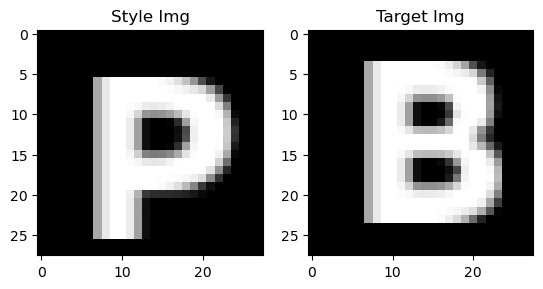

In [3]:
style_img, label_onehot, target_img = train_dataset[0]

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.title("Style Img")
plt.imshow(style_img.squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Target Img")
plt.imshow(target_img.squeeze(), cmap='gray')
plt.show()

In [4]:
train_dataset[0][0].shape, train_dataset[0][1].shape, train_dataset[0][2].shape
# style_img, label_onehot, target_img
# style_img: [1, 28, 28]
# label_onehot: [1, 62]
# target_img: [1, 28, 28]


(torch.Size([1, 28, 28]), torch.Size([62]), torch.Size([1, 28, 28]))

In [7]:
torch.cuda.is_available()

True

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class FontTransferCVAE(nn.Module):
    def __init__(self, label_dim=62, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Style Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + label_dim, 256)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),   # -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, label_onehot):
        z_cat = torch.cat([z, label_onehot], dim=1)
        return self.decoder(self.decoder_input(z_cat))

    def forward(self, style_img, label_onehot):
        mu, logvar = self.encode(style_img)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decode(z, label_onehot)
        return recon_img, mu, logvar, z  # ⬅️ 多返回一个 z，供 style loss 使用

def vae_loss(recon_x, target_x, mu, logvar, z, model, label_onehot, lambda_style=1.0):
    # reconstruction + KL divergence
    recon_loss = nn.functional.mse_loss(recon_x, target_x, reduction='mean')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / target_x.size(0)
    
    # === Style consistency loss ===
    with torch.no_grad():
        mu_gen, _ = model.encode(recon_x)  # 编码生成图像的风格
    style_loss = nn.functional.mse_loss(z, mu_gen, reduction='mean')  # ⬅️ 风格一致性损失

    total_loss = recon_loss + kl_loss + lambda_style * style_loss
    return total_loss, recon_loss.item(), kl_loss.item(), style_loss.item()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FontTransferCVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_loss = float('inf')
checkpoint_path = "best_model.pt"

try:
    model.load_state_dict(torch.load(checkpoint_path))
    print("Successfully loaded checkpoint, continue training.")
except FileNotFoundError:
    print("No checkpoint found, begin training")

total_losses = []
style_losses = []

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_style = 0
    for style_img, label_onehot, target_img in train_loader:
        style_img, label_onehot, target_img = style_img.to(device), label_onehot.to(device), target_img.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, z = model(style_img, label_onehot)
        loss, r_loss, kl, style = vae_loss(recon, target_img, mu, logvar, z, model, label_onehot)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_style += style
    
    avg_loss = total_loss / len(train_loader)
    avg_style = total_style / len(train_loader)
    
    total_losses.append(avg_loss)
    style_losses.append(avg_style)
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, StyleLoss: {avg_style:.4f}")
    
    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved (Loss: {best_loss:.4f})")

No checkpoint found, begin training
Epoch 1, Loss: 1.0600, StyleLoss: 0.9689
Best model saved (Loss: 1.0600)
Epoch 2, Loss: 1.0418, StyleLoss: 0.9684
Best model saved (Loss: 1.0418)
Epoch 3, Loss: 1.0312, StyleLoss: 0.9701
Best model saved (Loss: 1.0312)
Epoch 4, Loss: 1.0264, StyleLoss: 0.9693
Best model saved (Loss: 1.0264)
Epoch 5, Loss: 1.0258, StyleLoss: 0.9698
Best model saved (Loss: 1.0258)
Epoch 6, Loss: 1.0212, StyleLoss: 0.9659
Best model saved (Loss: 1.0212)
Epoch 7, Loss: 1.0251, StyleLoss: 0.9701
Epoch 8, Loss: 1.0254, StyleLoss: 0.9705
Epoch 9, Loss: 1.0246, StyleLoss: 0.9699
Epoch 10, Loss: 1.0247, StyleLoss: 0.9700
Epoch 11, Loss: 1.0248, StyleLoss: 0.9701
Epoch 12, Loss: 1.0240, StyleLoss: 0.9695
Epoch 13, Loss: 1.0254, StyleLoss: 0.9711
Epoch 14, Loss: 1.0235, StyleLoss: 0.9694
Epoch 15, Loss: 1.0256, StyleLoss: 0.9713
Epoch 16, Loss: 1.0222, StyleLoss: 0.9682
Epoch 17, Loss: 1.0229, StyleLoss: 0.9688
Epoch 18, Loss: 1.0243, StyleLoss: 0.9702
Epoch 19, Loss: 1.0246, S

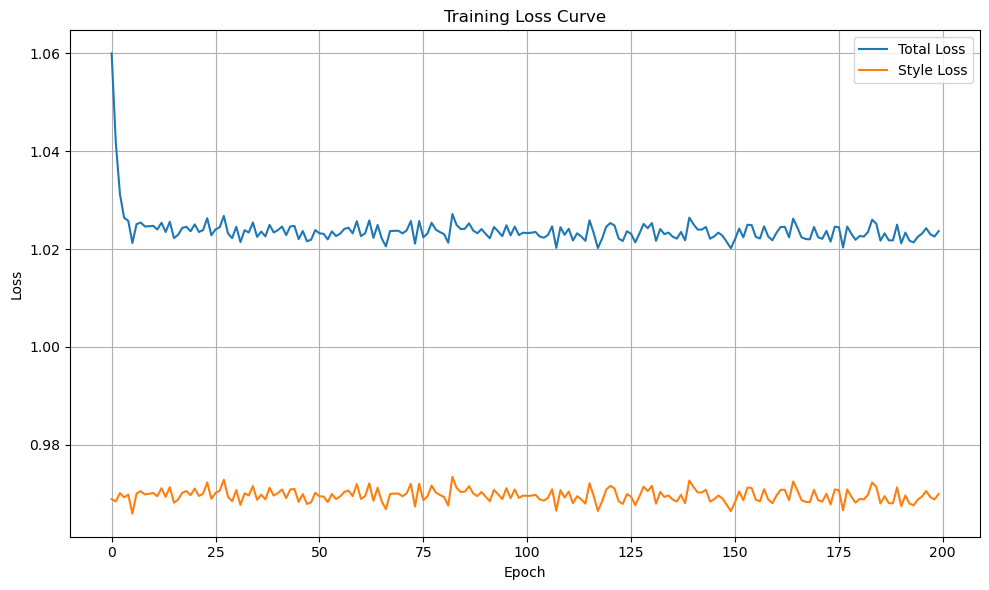

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(total_losses, label="Total Loss")
plt.plot(style_losses, label="Style Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_loss_curve.png")  # 保存图像
plt.show()

In [32]:
torch.save(model.state_dict(), "./data/cvae_font_transfer_style_loss_scheduler.pth")

In [33]:
# model = FontTransferCVAE(label_dim=62)
# model.load_state_dict(torch.load("./data/cvae_font_transfer.pth"))
model.to(device)
model.eval()

FontTransferCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder_input): Linear(in_features=126, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=3136, bias=True)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [34]:
# from eval import *
test_dataset = FontTransferDataset("./data/test_font_data.pkl", label_space)
test_loader = DataLoader(test_dataset, batch_size=64)


In [35]:
for style_img, label_tensor, target_img in test_loader:
    print(style_img.shape)
    print(label_tensor.shape)
    print(target_img.shape)
    break

# torch.Size([64, 1, 28, 28])
# torch.Size([64, 62])
# torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])
torch.Size([64, 62])
torch.Size([64, 1, 28, 28])


In [36]:
test_dataset[0][0].shape, test_dataset[0][1].shape, test_dataset[0][2].shape
# style_img, label_onehot, target_img
# style_img: [1, 28, 28]
# label_onehot: [62]
# target_img: [1, 28, 28]


(torch.Size([1, 28, 28]), torch.Size([62]), torch.Size([1, 28, 28]))

In [37]:
import torch
import matplotlib.pyplot as plt

def label_to_onehot(label, label_space=label_space):
    """
    Convert a character label into a one-hot encoded tensor.

    Args:
        label (str): A single character, e.g., 'A'
        label_space (list of str): The list of allowed characters, length 62

    Returns:
        Tensor: One-hot encoded tensor of shape [62]
    """
    index = label_space.index(label)
    return torch.nn.functional.one_hot(torch.tensor(index), num_classes=len(label_space)).float()

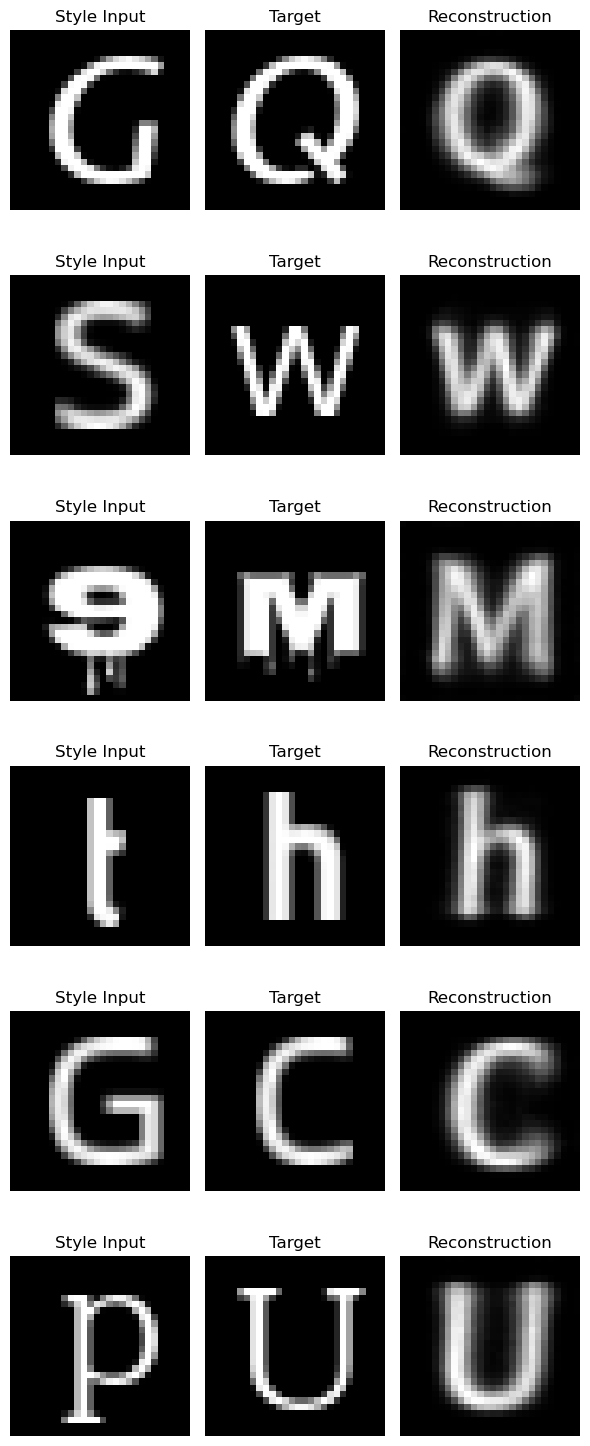

In [38]:
import torch
import matplotlib.pyplot as plt

# 假设已定义:
# - model (加载好并 .eval())
# - test_loader
# - device

# 设置展示数量
samples_to_show = 6

# 创建子图
fig, axes = plt.subplots(samples_to_show, 3, figsize=(6, 2.5 * samples_to_show))

# 推理 & 可视化
model.eval()
with torch.no_grad():
    for style_img, label_tensor, target_img in test_loader:
        # 提取前 N 个样本
        style_img = style_img[:samples_to_show].to(device)      # [N, 1, 28, 28]
        label_tensor = label_tensor[:samples_to_show].to(device)  # [N, 62]
        target_img = target_img[:samples_to_show].to(device)    # [N, 1, 28, 28]

        recon_img, _, _, _ = model(style_img, label_tensor)        # [N, 1, 28, 28]

        for i in range(samples_to_show):
            axes[i, 0].imshow(style_img[i].cpu().squeeze(), cmap='gray')
            axes[i, 0].set_title("Style Input")

            axes[i, 1].imshow(target_img[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title("Target")

            axes[i, 2].imshow(recon_img[i].cpu().squeeze(), cmap='gray')
            axes[i, 2].set_title("Reconstruction")

            for ax in axes[i]:
                ax.axis('off')

        break  # 只处理一批

plt.tight_layout()
plt.show()

In [39]:
total_count = 0
for style_img, label_tensor, target_img in test_loader:
    total_count += style_img.size(0)
print(f"Total test samples: {total_count}")

Total test samples: 2000


Displaying 15 samples...


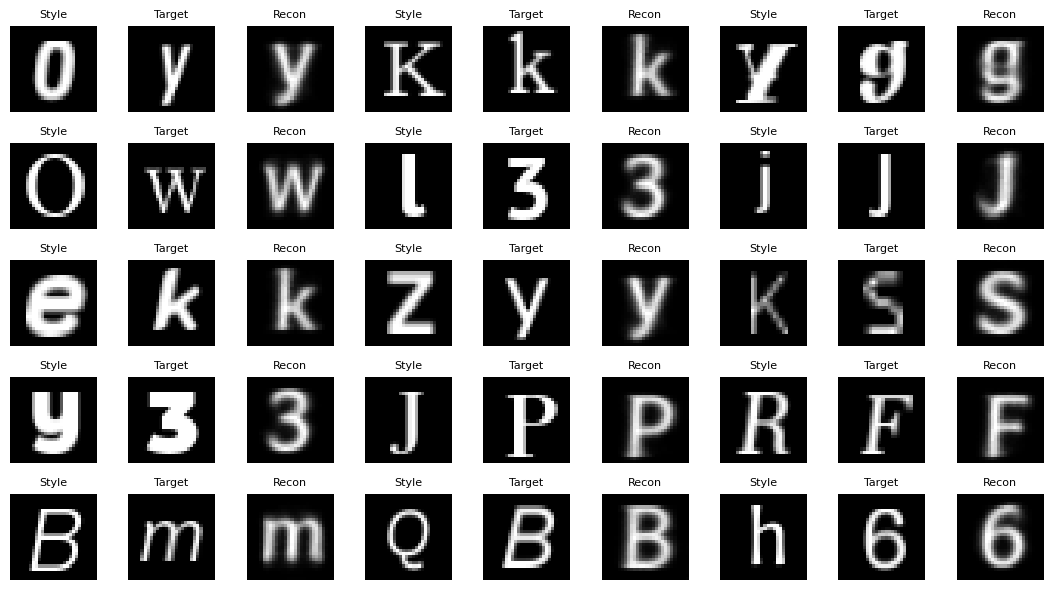

In [40]:
import torch
import matplotlib.pyplot as plt
import random

# 参数设定
show_all = False          # True 显示全部样本；False 时随机选一部分
samples_to_show = 15      # 随机显示的样本数量（若 show_all=False）
triplets_per_row = 3      # 每行显示几个三元组（style, target, recon）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 收集全部样本
model.eval()
all_style_imgs, all_target_imgs, all_recon_imgs = [], [], []

with torch.no_grad():
    for style_img, label_tensor, target_img in test_loader:
        style_img = style_img.to(device)
        label_tensor = label_tensor.to(device)
        target_img = target_img.to(device)

        recon_img, _, _, _ = model(style_img, label_tensor)

        all_style_imgs.append(style_img.cpu())
        all_target_imgs.append(target_img.cpu())
        all_recon_imgs.append(recon_img.cpu())

# 拼接成完整集合
all_style_imgs = torch.cat(all_style_imgs, dim=0)
all_target_imgs = torch.cat(all_target_imgs, dim=0)
all_recon_imgs = torch.cat(all_recon_imgs, dim=0)

total_samples = all_style_imgs.size(0)

# 选择要展示的索引
if show_all:
    indices = list(range(total_samples))
else:
    indices = random.sample(range(total_samples), min(samples_to_show, total_samples))

n_show = len(indices)
print(f"Displaying {n_show} samples...")

# 布局计算
n_cols = triplets_per_row * 3  # 每组3张图
n_rows = (n_show + triplets_per_row - 1) // triplets_per_row  # 向上取整行数

# 创建子图，图像更小
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2))

# 保证 axes 是二维数组
if n_rows == 1:
    axes = axes.reshape(1, -1)

# 开始画图
for i, idx in enumerate(indices):
    row = i // triplets_per_row
    col_start = (i % triplets_per_row) * 3

    axes[row, col_start + 0].imshow(all_style_imgs[idx].squeeze(), cmap='gray')
    axes[row, col_start + 0].set_title("Style", fontsize=8)
    
    axes[row, col_start + 1].imshow(all_target_imgs[idx].squeeze(), cmap='gray')
    axes[row, col_start + 1].set_title("Target", fontsize=8)
    
    axes[row, col_start + 2].imshow(all_recon_imgs[idx].squeeze(), cmap='gray')
    axes[row, col_start + 2].set_title("Recon", fontsize=8)

    # 去掉坐标轴
    for j in range(3):
        axes[row, col_start + j].axis('off')

plt.tight_layout()
plt.show()


Displaying 24 samples with label = 0...


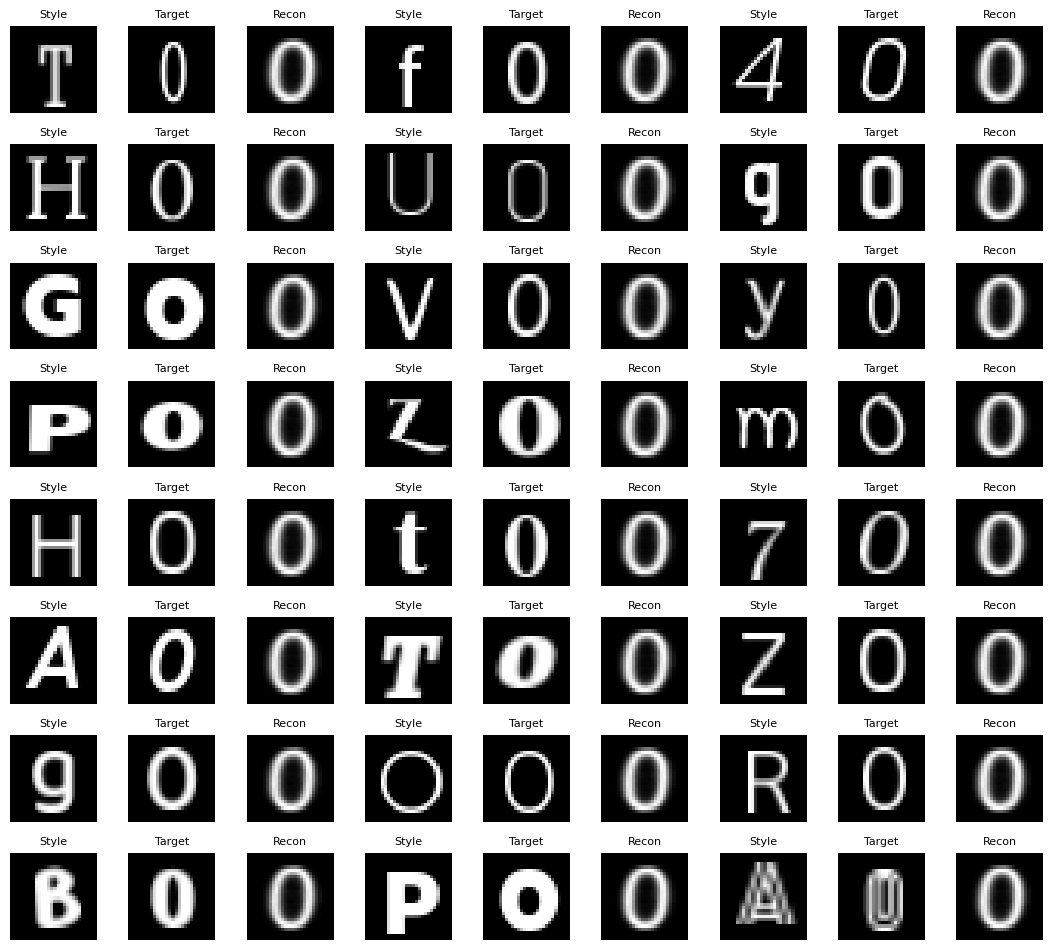

In [41]:
import torch
import matplotlib.pyplot as plt
import random

# 参数设定
show_all = True           # True 显示全部样本；False 时随机选一部分
samples_to_show = 15       # 随机显示的样本数量（若 show_all=False）
triplets_per_row = 3       # 每行显示几个三元组（style, target, recon）

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 收集全部样本（包括 label）
model.eval()
all_style_imgs, all_target_imgs, all_recon_imgs, all_labels = [], [], [], []

first_label_value = 0  # 记录第一个 label 作为筛选目标

with torch.no_grad():
    for style_img, label_tensor, target_img in test_loader:
        style_img = style_img.to(device)
        label_tensor = label_tensor.to(device)
        target_img = target_img.to(device)

        recon_img, _, _, _ = model(style_img, label_tensor)

        all_style_imgs.append(style_img.cpu())
        all_target_imgs.append(target_img.cpu())
        all_recon_imgs.append(recon_img.cpu())

        # 自动提取 label：如果是 one-hot 或嵌入，取 argmax
        if label_tensor.ndim > 1:
            label_ids = label_tensor.argmax(dim=1).cpu()
        else:
            label_ids = label_tensor.cpu()

        # 记录第一个 label 值
        # if first_label_value is None:
        #     first_label_value = label_ids[0].item()

        all_labels.append(label_ids)

# 拼接为完整 tensor
all_style_imgs = torch.cat(all_style_imgs, dim=0)
all_target_imgs = torch.cat(all_target_imgs, dim=0)
all_recon_imgs = torch.cat(all_recon_imgs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# 根据标签筛选出目标类的索引
target_indices = (all_labels == first_label_value).nonzero(as_tuple=True)[0].tolist()

if not target_indices:
    print(f"No samples found with label {first_label_value}")
    exit()

# 选择要展示的索引
if show_all:
    indices = target_indices
else:
    indices = random.sample(target_indices, min(samples_to_show, len(target_indices)))

n_show = len(indices)
print(f"Displaying {n_show} samples with label = {first_label_value}...")

# 布局计算
n_cols = triplets_per_row * 3  # 每组3张图
n_rows = (n_show + triplets_per_row - 1) // triplets_per_row  # 向上取整行数

# 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2))

# 保证 axes 是二维数组
if n_rows == 1:
    axes = axes.reshape(1, -1)

# 开始画图
for i, idx in enumerate(indices):
    row = i // triplets_per_row
    col_start = (i % triplets_per_row) * 3

    axes[row, col_start + 0].imshow(all_style_imgs[idx].squeeze(), cmap='gray')
    axes[row, col_start + 0].set_title("Style", fontsize=8)

    axes[row, col_start + 1].imshow(all_target_imgs[idx].squeeze(), cmap='gray')
    axes[row, col_start + 1].set_title("Target", fontsize=8)

    axes[row, col_start + 2].imshow(all_recon_imgs[idx].squeeze(), cmap='gray')
    axes[row, col_start + 2].set_title("Recon", fontsize=8)

    # 去掉坐标轴
    for j in range(3):
        axes[row, col_start + j].axis('off')

plt.tight_layout()
plt.show()


### Extract pretrained VGG features to evaluate the style similarity

To evaluate style similarity, we extracted shallow features from pretrained VGGNet (specifically from the relu2_2 layer), which is a commonly used evaluation indicator in style transfer tasks. This layer captures low-level texture and edge information, which is indicative of visual style.

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np

# Define a feature extractor using pretrained VGG16 up to relu3_3
class VGGStyleFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        self.slice = nn.Sequential(*[vgg[i] for i in range(9)])  # Up to relu3_3
        for param in self.slice.parameters():
            param.requires_grad = False  # Freeze parameters

    def forward(self, x):
        return self.slice(x)

# Compute cosine similarity between two batches of feature maps
def cosine_sim(feat1, feat2):
    feat1 = F.adaptive_avg_pool2d(feat1, 1).squeeze()  # Global average pooling
    feat2 = F.adaptive_avg_pool2d(feat2, 1).squeeze()

    if len(feat1.shape) == 1:
        feat1 = feat1.unsqueeze(0)
        feat2 = feat2.unsqueeze(0)

    feat1 = F.normalize(feat1, dim=1)  # Normalize features
    feat2 = F.normalize(feat2, dim=1)
    return (feat1 * feat2).sum(dim=1)  # Cosine similarity

# Preprocess grayscale images for VGG input
def preprocess_for_vgg(img_batch):
    if img_batch.shape[1] == 1:
        img_batch = img_batch.repeat(1, 3, 1, 1)  # Convert 1-channel to 3-channel
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])(img_batch)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_extractor = VGGStyleFeatureExtractor().to(device).eval()

# Lists to store similarity scores
sim_style_recon = []
sim_style_target = []
sim_recon_target = []

# Evaluate similarity across the test set
with torch.no_grad():
    for style_img, label_tensor, target_img in tqdm(test_loader, desc="Evaluating style similarity"):
        style_img = style_img.to(device)
        label_tensor = label_tensor.to(device)
        target_img = target_img.to(device)

        # Generate reconstructed image using your CVAE model
        recon_img, _, _, _ = model(style_img, label_tensor)

        # Preprocess images for VGG input
        style_vgg = preprocess_for_vgg(style_img)
        recon_vgg = preprocess_for_vgg(recon_img)
        target_vgg = preprocess_for_vgg(target_img)

        # Extract VGG features
        style_feat = vgg_extractor(style_vgg)
        recon_feat = vgg_extractor(recon_vgg)
        target_feat = vgg_extractor(target_vgg)
        
        # Compute cosine similarities
        sim_sr = cosine_sim(style_feat, recon_feat)    # style vs recon
        sim_st = cosine_sim(style_feat, target_feat)   # style vs target
        sim_rt = cosine_sim(recon_feat, target_feat)   # recon vs target

        # Accumulate results
        sim_style_recon.extend(sim_sr.cpu().tolist())
        sim_style_target.extend(sim_st.cpu().tolist())
        sim_recon_target.extend(sim_rt.cpu().tolist())

# Print average similarity scores
print(f"Average Style–Recon similarity:  {np.mean(sim_style_recon):.4f}")
print(f"Average Style–Target similarity: {np.mean(sim_style_target):.4f}")
print(f"Average Recon–Target similarity: {np.mean(sim_recon_target):.4f}")


Evaluating style similarity: 100%|██████████| 32/32 [00:00<00:00, 71.39it/s]

Average Style–Recon similarity:  0.8972
Average Style–Target similarity: 0.9556
Average Recon–Target similarity: 0.9239


The cos similarity results showed that the similarity of reconstructed images and style images are lower than that of style images and target images, suggesting that the model's ability to learn style is suboptimal.

In [43]:
import torch.nn.functional as F

# Function to compute the Gram matrix of a batch of feature maps
def gram_matrix(feat):
    B, C, H, W = feat.size()
    feat = feat.view(B, C, -1)  # Flatten to [B, C, H*W]
    gram = torch.bmm(feat, feat.transpose(1, 2))  # [B, C, C]
    return gram / (C * H * W)  # Normalize

# Evaluate style similarity (smaller MSE means more similar style)
style_recon_distances = []
style_target_distances = []
recon_target_distances = []

with torch.no_grad():
    for style_img, label_tensor, target_img in tqdm(test_loader, desc="Evaluating style similarity (Gram)"):
        style_img = style_img.to(device)
        label_tensor = label_tensor.to(device)
        target_img = target_img.to(device)

        recon_img, _, _, _ = model(style_img, label_tensor)

        # Preprocess for VGG
        style_img_vgg = preprocess_for_vgg(style_img)
        recon_img_vgg = preprocess_for_vgg(recon_img)
        target_img_vgg = preprocess_for_vgg(target_img)

        # Extract VGG features
        style_feat = vgg_extractor(style_img_vgg)
        recon_feat = vgg_extractor(recon_img_vgg)
        target_feat = vgg_extractor(target_img_vgg)

        # Compute Gram matrices
        gram_style = gram_matrix(style_feat)
        gram_recon = gram_matrix(recon_feat)
        gram_target = gram_matrix(target_feat)

        # Compute mean squared error between Gram matrices
        dist_style_recon = F.mse_loss(gram_style, gram_recon, reduction='none').mean(dim=[1, 2])  # [B]
        dist_style_target = F.mse_loss(gram_style, gram_target, reduction='none').mean(dim=[1, 2])
        dist_recon_target = F.mse_loss(gram_recon, gram_target, reduction='none').mean(dim=[1, 2])

        style_recon_distances.extend(dist_style_recon.cpu().tolist())
        style_target_distances.extend(dist_style_target.cpu().tolist())
        recon_target_distances.extend(dist_recon_target.cpu().tolist())

# Final report (lower means more similar)
print(f"Average Style–Recon style distance (Gram):  {np.mean(style_recon_distances):.4f}")
print(f"Average Style–Target style distance (Gram): {np.mean(style_target_distances):.4f}")
print(f"Average Recon–Target style distance (Gram): {np.mean(recon_target_distances):.4f}")

Evaluating style similarity (Gram): 100%|██████████| 32/32 [00:00<00:00, 75.40it/s]

Average Style–Recon style distance (Gram):  0.0017
Average Style–Target style distance (Gram): 0.0011
Average Recon–Target style distance (Gram): 0.0015


The Gram matrix distances results matched the cos similarity results.